<a href="https://colab.research.google.com/github/AsadiAhmad/Colorize-Grayscale-Images/blob/main/Code/Colorize_Grayscale_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Import Libraries

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import gdown

# Step 2: Download Resources

In [2]:
gdown.download(id="1LvgEe5DnG_Vpd6n9laUlfgi1BCrG4dkv", output="pts_in_hull.npy", quiet=False)
gdown.download(id="1yNtqZ0YueocX9TCET2hcK18XRbieR-Jv", output="colorization_release_v2.caffemodel", quiet=False)
gdown.download(id="1hS6a-taPesUwPTqQ8wH32LJqybUov6Vs", output="colorization_deploy_v2.prototxt", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1LvgEe5DnG_Vpd6n9laUlfgi1BCrG4dkv
To: /content/pts_in_hull.npy
100%|██████████| 5.09k/5.09k [00:00<00:00, 8.01MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1yNtqZ0YueocX9TCET2hcK18XRbieR-Jv
From (redirected): https://drive.google.com/uc?id=1yNtqZ0YueocX9TCET2hcK18XRbieR-Jv&confirm=t&uuid=6fa1e950-36ae-444d-a6d9-8d6550b68095
To: /content/colorization_release_v2.caffemodel
100%|██████████| 129M/129M [00:01<00:00, 65.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hS6a-taPesUwPTqQ8wH32LJqybUov6Vs
To: /content/colorization_deploy_v2.prototxt
100%|██████████| 9.95k/9.95k [00:00<00:00, 16.1MB/s]


'colorization_deploy_v2.prototxt'

In [3]:
!wget https://raw.githubusercontent.com/AsadiAhmad/Colorize-Grayscale-Images/main/Pictures/mansion.jpg -O mansion.jpg

--2025-05-05 20:26:19--  https://raw.githubusercontent.com/AsadiAhmad/Colorize-Grayscale-Images/main/Pictures/mansion.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2074827 (2.0M) [image/jpeg]
Saving to: ‘mansion.jpg’

mansion.jpg         100%[===================>]   1.98M  --.-KB/s    in 0.01s   

2025-05-05 20:26:19 (205 MB/s) - ‘mansion.jpg’ saved [2074827/2074827]



# Step 3: Load Image

In [4]:
image = cv.imread('mansion.jpg')
grayscale_image = cv.imread('mansion.jpg', cv.IMREAD_GRAYSCALE)
grayscale_rgb = cv.cvtColor(grayscale_image, cv.COLOR_GRAY2RGB)

scaled = grayscale_rgb.astype("float32")/255.0
lab = cv.cvtColor(scaled, cv.COLOR_RGB2LAB)

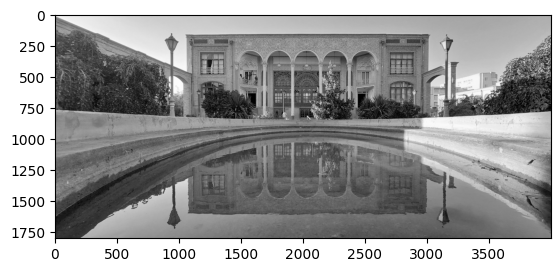

In [5]:
plt.imshow(grayscale_rgb)
plt.show()

# Step 4: Initialize Neural Network

In [6]:
prototxt_src = "colorization_deploy_v2.prototxt"
model_src = "colorization_release_v2.caffemodel"
pts_src = "pts_in_hull.npy"

net = cv.dnn.readNetFromCaffe(prototxt_src, model_src)
kernel = np.load(pts_src)

kernel = kernel.transpose().reshape(2,313,1,1)
class8 = net.getLayerId("class8_ab")
conv8 =  net.getLayerId("conv8_313_rh")
net.getLayer(class8).blobs = [kernel.astype(np.float32)]
net.getLayer(conv8).blobs = [np.full([1,313],2.606,dtype=np.float32)]

# Step 5: Resize Image

In [7]:
resized = cv.resize(lab,(224,224))
L_resized = cv.split(resized)[0] # others
L_resized -= 50

# Step 6: Forward Pass and colorize the Image

In [8]:
net.setInput(cv.dnn.blobFromImage(L_resized))
ab_channels = net.forward()[0, :, :, :].transpose((1, 2, 0))
ab_channels = cv.resize(ab_channels, (grayscale_rgb.shape[1], grayscale_rgb.shape[0]))

In [9]:
ab_channels *= 1.3

# Step 7: Convert LAB to BGR

In [10]:
L_resized = cv.split(lab)[0]
colorized = np.concatenate((L_resized[:,:,np.newaxis], ab_channels), axis=2)
colorized = cv.cvtColor(colorized,cv.COLOR_LAB2BGR)
colorized = np.clip(colorized,0,1)
colorized = (255 * colorized).astype("uint8")

# Step 8: Boost Saturation

In [11]:
hsv = cv.cvtColor(colorized, cv.COLOR_BGR2HSV)
hsv[..., 1] = np.clip(hsv[..., 1] * 1.25, 0, 255)
colorized = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)

# Step 9: Warm Shift

In [12]:
colorized = colorized.astype(np.float32)
colorized[..., 2] *= 1.03  # Red
colorized[..., 1] *= 1.01  # Green
colorized = np.clip(colorized, 0, 255).astype(np.uint8)

# Step 10: Show Image

In [13]:
cv.imwrite('output.jpg', colorized)

True

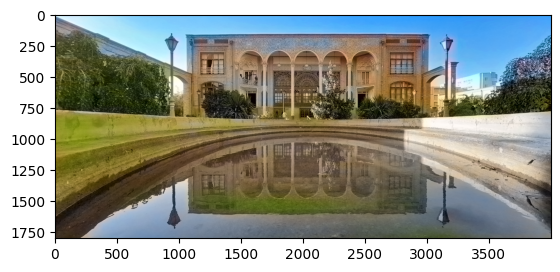

In [14]:
plt.imshow(colorized[...,::-1])

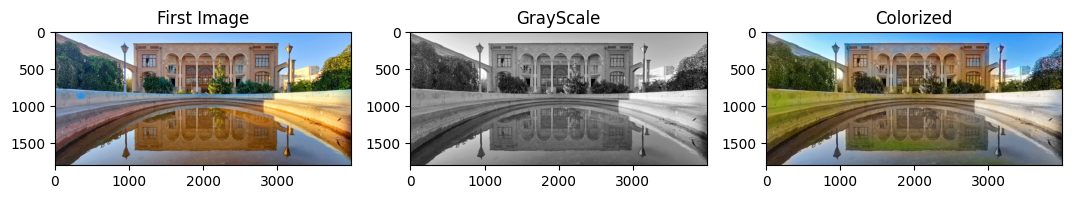

In [15]:
plt.figure(figsize=[13, 6])
plt.subplot(131),plt.imshow(image[...,::-1]),plt.title('First Image');
plt.subplot(132),plt.imshow(grayscale_rgb[...,::-1]),plt.title('GrayScale');
plt.subplot(133),plt.imshow(colorized[...,::-1]),plt.title('Colorized');